In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!pip install --quiet norse

In [5]:
import torchvision

BATCH_SIZE = 256

transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,)),
    ]
)

train_data = torchvision.datasets.MNIST(
    root=".",
    train=True,
    download=True,
    transform=transform,
)

train_loader = torch.utils.data.DataLoader(
    train_data, batch_size=BATCH_SIZE, shuffle=True
)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(
        root=".",
        train=False,
        transform=transform,
    ),
    batch_size=BATCH_SIZE,
)

In [7]:
from norse.torch import ConstantCurrentLIFEncoder

/Users/sophie/miniconda3/envs/neuromorphic_env/lib/python3.9/site-packages/torch/utils/_cxx_pytree.py:238: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFParameters'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(
/Users/sophie/miniconda3/envs/neuromorphic_env/lib/python3.9/site-packages/torch/utils/_cxx_pytree.py:238: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFState'> is a subclass of `collections.namedtuple`, which is already registered in the global namespace. Override it with custom flatten/unflatten functions in namespace 'torch'.
  optree.register_pytree_node(
/Users/sophie/miniconda3/envs/neuromorphic_env/lib/python3.9/site-packages/torch/utils/_cxx_pytree.py:238: UserWarning: PyTree type <class 'norse.torch.utils.pytree.LIFFeedForwardState'> is a subclass of `collections.namedtuple`, which is al

1


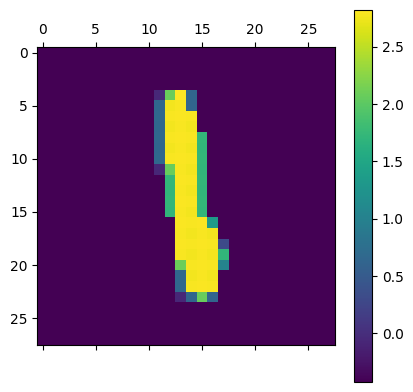

In [75]:
img, label = train_data[200]

plt.matshow(img[0])
plt.colorbar()
print(label)

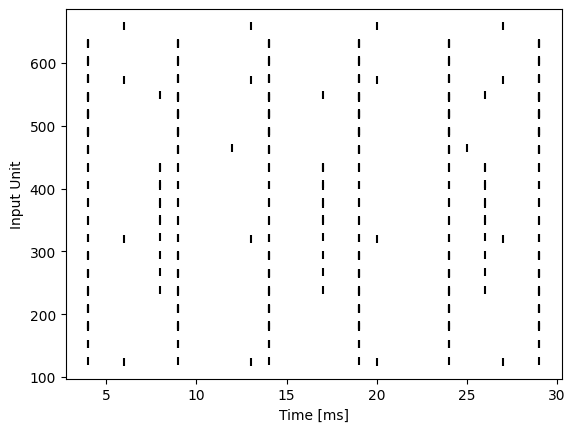

In [77]:
T = 32
example_encoder = ConstantCurrentLIFEncoder(T)


example_input = example_encoder(img)
example_spikes = example_input.reshape(T, 28 * 28).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Unit")
plt.xlabel("Time [ms]")
plt.show()

In [79]:
from norse.torch import PoissonEncoder

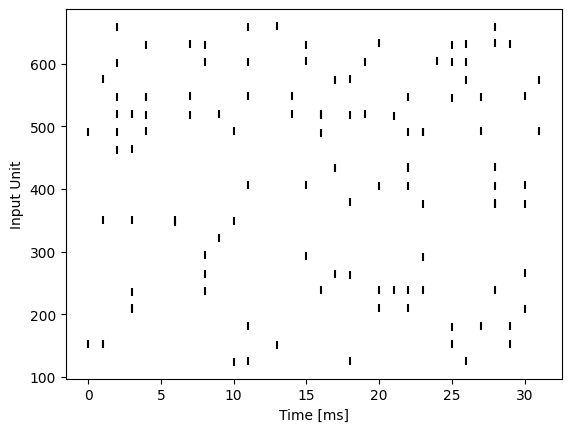

In [81]:
T = 32
example_encoder = PoissonEncoder(T, f_max=20)

example_input = example_encoder(img)
example_spikes = example_input.reshape(T, 28 * 28).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Unit")
plt.xlabel("Time [ms]")
plt.show()

In [83]:
from norse.torch import SpikeLatencyLIFEncoder

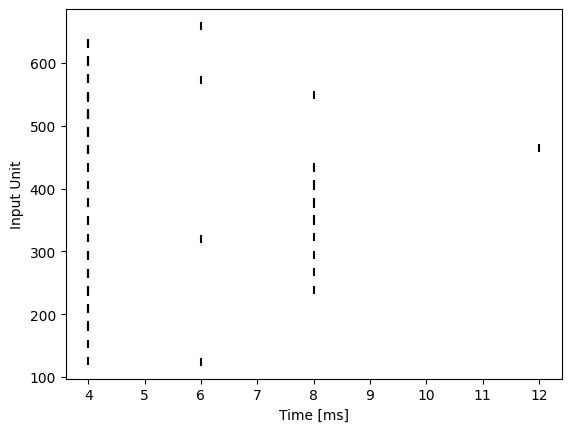

In [85]:
T = 32
example_encoder = SpikeLatencyLIFEncoder(T)


example_input = example_encoder(img)
example_spikes = example_input.reshape(T, 28 * 28).to_sparse().coalesce()
t = example_spikes.indices()[0]
n = example_spikes.indices()[1]

plt.scatter(t, n, marker="|", color="black")
plt.ylabel("Input Unit")
plt.xlabel("Time [ms]")
plt.show()

In [21]:
from norse.torch import LIFParameters, LIFState
from norse.torch.module.lif import LIFCell, LIFRecurrentCell

# Notice the difference between "LIF" (leaky integrate-and-fire) and "LI" (leaky integrator)
from norse.torch import LICell, LIState

from typing import NamedTuple


class SNNState(NamedTuple):
    lif0: LIFState
    readout: LIState


class SNN(torch.nn.Module):
    def __init__(
        self, input_features, hidden_features, output_features, record=False, dt=0.001
    ):
        super(SNN, self).__init__()
        self.l1 = LIFRecurrentCell(
            input_features,
            hidden_features,
            p=LIFParameters(alpha=100, v_th=torch.tensor(0.5)),
            dt=dt,
        )
        self.input_features = input_features
        self.fc_out = torch.nn.Linear(hidden_features, output_features, bias=False)
        self.out = LICell(dt=dt)

        self.hidden_features = hidden_features
        self.output_features = output_features
        self.record = record

    def forward(self, x):
        seq_length, batch_size, _, _, _ = x.shape
        s1 = so = None
        voltages = []

        if self.record:
            self.recording = SNNState(
                LIFState(
                    z=torch.zeros(seq_length, batch_size, self.hidden_features),
                    v=torch.zeros(seq_length, batch_size, self.hidden_features),
                    i=torch.zeros(seq_length, batch_size, self.hidden_features),
                ),
                LIState(
                    v=torch.zeros(seq_length, batch_size, self.output_features),
                    i=torch.zeros(seq_length, batch_size, self.output_features),
                ),
            )

        for ts in range(seq_length):
            z = x[ts, :, :, :].view(-1, self.input_features)
            z, s1 = self.l1(z, s1)
            z = self.fc_out(z)
            vo, so = self.out(z, so)
            if self.record:
                self.recording.lif0.z[ts, :] = s1.z
                self.recording.lif0.v[ts, :] = s1.v
                self.recording.lif0.i[ts, :] = s1.i
                self.recording.readout.v[ts, :] = so.v
                self.recording.readout.i[ts, :] = so.i
            voltages += [vo]

        return torch.stack(voltages)

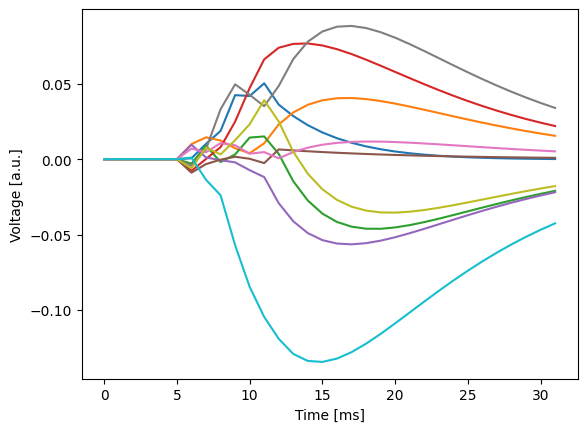

In [23]:
example_snn = SNN(28 * 28, 100, 10, record=True, dt=0.001)

example_readout_voltages = example_snn(example_input.unsqueeze(1))
voltages = example_readout_voltages.squeeze(1).detach().numpy()

plt.plot(voltages)
plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()

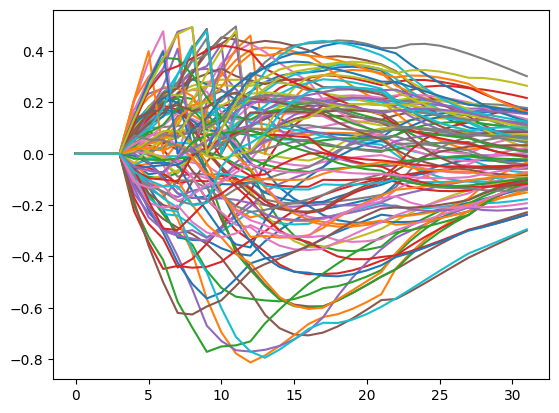

In [25]:
plt.plot(example_snn.recording.lif0.v.squeeze(1).detach().numpy())
plt.show()

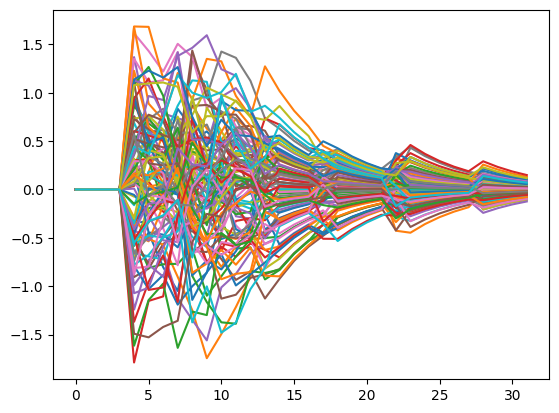

In [27]:
plt.plot(example_snn.recording.lif0.i.squeeze(1).detach().numpy())
plt.show()

In [29]:
def decode(x):
    x, _ = torch.max(x, 0)
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

In [31]:
def decode_last(x):
    x = x[-1]
    log_p_y = torch.nn.functional.log_softmax(x, dim=1)
    return log_p_y

In [33]:
class Model(torch.nn.Module):
    def __init__(self, encoder, snn, decoder):
        super(Model, self).__init__()
        self.encoder = encoder
        self.snn = snn
        self.decoder = decoder

    def forward(self, x):
        x = self.encoder(x)
        x = self.snn(x)
        log_p_y = self.decoder(x)
        return log_p_y

In [35]:
T = 32
LR = 0.002
INPUT_FEATURES = 28 * 28
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 10

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = Model(
    encoder=ConstantCurrentLIFEncoder(
        seq_length=T,
    ),
    snn=SNN(
        input_features=INPUT_FEATURES,
        hidden_features=HIDDEN_FEATURES,
        output_features=OUTPUT_FEATURES,
    ),
    decoder=decode,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (encoder): ConstantCurrentLIFEncoder()
  (snn): SNN(
    (l1): LIFRecurrentCell(input_size=784, hidden_size=100, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.5000), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.001)
    (fc_out): Linear(in_features=100, out_features=10, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
)

In [37]:
from torch.utils.data import random_split

# Aufteilen des Trainingsdatensatzes in Trainings- und Validierungsdatensatz
val_size = int(0.2 * len(train_data))  # 20% für Validierung
train_size = len(train_data) - val_size
train_data, val_data = random_split(train_data, [train_size, val_size])

# DataLoader für den Validierungsdatensatz
val_loader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False)


In [39]:
def validate(model, device, val_loader):
    model.eval()
    val_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in val_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            val_loss += torch.nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    val_loss /= len(val_loader.dataset)
    accuracy = 100.0 * correct / len(val_loader.dataset)

    return val_loss, accuracy


In [41]:
from tqdm.notebook import tqdm, trange

EPOCHS = 60  # Increase this number for better performance


def train(model, device, train_loader, optimizer, epoch, max_epochs):
    model.train()
    losses = []

    for (data, target) in tqdm(train_loader, leave=False):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = torch.nn.functional.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    mean_loss = np.mean(losses)
    return losses, mean_loss

In [43]:
def test(model, device, test_loader, epoch):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += torch.nn.functional.nll_loss(
                output, target, reduction="sum"
            ).item()  # sum up batch loss
            pred = output.argmax(
                dim=1, keepdim=True
            )  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    accuracy = 100.0 * correct / len(test_loader.dataset)

    return test_loss, accuracy

In [45]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in trange(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    
    # Training
    training_loss, mean_loss = train(
        model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS
    )
    
    # Test
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    
    # Validation
    val_loss, val_accuracy = validate(model, DEVICE, val_loader)
    
    # Update der Metriken
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy)
    
    # Falls NaN oder unendlicher Verlust erkannt wurde, breche das Training ab
    if mean_loss == 0.0 or test_loss == 0.0 or val_loss == 0.0:
        print("Training wegen NaN oder unendlichem Verlust abgebrochen.")
        break

    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train Loss: {mean_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Accuracy: {accuracy:.2f}%, "
          f"Validation Accuracy: {val_accuracy:.2f}%")

print(f"Final Test Accuracy: {accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {validation_accuracies[-1]:.2f}%")


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1/60 - Train Loss: 0.5377, Test Loss: 0.2764, Validation Loss: 0.2681, Accuracy: 91.44%, Validation Accuracy: 91.95%
Epoch 2/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/60 - Train Loss: 0.2388, Test Loss: 0.2103, Validation Loss: 0.1997, Accuracy: 93.47%, Validation Accuracy: 93.88%
Epoch 3/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/60 - Train Loss: 0.1913, Test Loss: 0.1833, Validation Loss: 0.1638, Accuracy: 94.27%, Validation Accuracy: 94.96%
Epoch 4/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4/60 - Train Loss: 0.1619, Test Loss: 0.1621, Validation Loss: 0.1310, Accuracy: 95.03%, Validation Accuracy: 95.94%
Epoch 5/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5/60 - Train Loss: 0.1447, Test Loss: 0.1682, Validation Loss: 0.1347, Accuracy: 94.59%, Validation Accuracy: 95.79%
Epoch 6/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6/60 - Train Loss: 0.1318, Test Loss: 0.1524, Validation Loss: 0.1131, Accuracy: 95.28%, Validation Accuracy: 96.58%
Epoch 7/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7/60 - Train Loss: 0.1176, Test Loss: 0.1565, Validation Loss: 0.1111, Accuracy: 95.30%, Validation Accuracy: 96.48%
Epoch 8/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8/60 - Train Loss: 0.1124, Test Loss: 0.1399, Validation Loss: 0.0942, Accuracy: 95.59%, Validation Accuracy: 97.03%
Epoch 9/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9/60 - Train Loss: 0.1042, Test Loss: 0.1398, Validation Loss: 0.0975, Accuracy: 95.62%, Validation Accuracy: 96.73%
Epoch 10/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10/60 - Train Loss: 0.0989, Test Loss: 0.1518, Validation Loss: 0.1051, Accuracy: 95.53%, Validation Accuracy: 96.79%
Epoch 11/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11/60 - Train Loss: 0.0881, Test Loss: 0.1404, Validation Loss: 0.0839, Accuracy: 95.67%, Validation Accuracy: 97.28%
Epoch 12/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12/60 - Train Loss: 0.0892, Test Loss: 0.1219, Validation Loss: 0.0693, Accuracy: 96.26%, Validation Accuracy: 97.71%
Epoch 13/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13/60 - Train Loss: 0.0818, Test Loss: 0.1517, Validation Loss: 0.0858, Accuracy: 95.74%, Validation Accuracy: 97.25%
Epoch 14/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14/60 - Train Loss: 0.0803, Test Loss: 0.1404, Validation Loss: 0.0764, Accuracy: 95.94%, Validation Accuracy: 97.54%
Epoch 15/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15/60 - Train Loss: 0.0753, Test Loss: 0.1240, Validation Loss: 0.0632, Accuracy: 96.28%, Validation Accuracy: 97.92%
Epoch 16/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16/60 - Train Loss: 0.0765, Test Loss: 0.1221, Validation Loss: 0.0679, Accuracy: 96.29%, Validation Accuracy: 97.89%
Epoch 17/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17/60 - Train Loss: 0.0666, Test Loss: 0.1232, Validation Loss: 0.0673, Accuracy: 96.24%, Validation Accuracy: 97.75%
Epoch 18/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18/60 - Train Loss: 0.0666, Test Loss: 0.1340, Validation Loss: 0.0599, Accuracy: 96.19%, Validation Accuracy: 98.03%
Epoch 19/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19/60 - Train Loss: 0.0651, Test Loss: 0.1233, Validation Loss: 0.0479, Accuracy: 96.57%, Validation Accuracy: 98.53%
Epoch 20/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 20/60 - Train Loss: 0.0598, Test Loss: 0.1306, Validation Loss: 0.0579, Accuracy: 96.45%, Validation Accuracy: 98.07%
Epoch 21/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 21/60 - Train Loss: 0.0571, Test Loss: 0.1284, Validation Loss: 0.0482, Accuracy: 96.51%, Validation Accuracy: 98.42%
Epoch 22/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 22/60 - Train Loss: 0.0584, Test Loss: 0.1251, Validation Loss: 0.0505, Accuracy: 96.40%, Validation Accuracy: 98.31%
Epoch 23/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 23/60 - Train Loss: 0.0520, Test Loss: 0.1220, Validation Loss: 0.0439, Accuracy: 96.68%, Validation Accuracy: 98.47%
Epoch 24/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 24/60 - Train Loss: 0.0520, Test Loss: 0.1268, Validation Loss: 0.0468, Accuracy: 96.49%, Validation Accuracy: 98.50%
Epoch 25/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 25/60 - Train Loss: 0.0489, Test Loss: 0.1244, Validation Loss: 0.0370, Accuracy: 96.62%, Validation Accuracy: 98.94%
Epoch 26/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 26/60 - Train Loss: 0.0484, Test Loss: 0.1251, Validation Loss: 0.0437, Accuracy: 96.48%, Validation Accuracy: 98.66%
Epoch 27/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 27/60 - Train Loss: 0.0488, Test Loss: 0.1266, Validation Loss: 0.0384, Accuracy: 96.50%, Validation Accuracy: 98.80%
Epoch 28/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 28/60 - Train Loss: 0.0472, Test Loss: 0.1262, Validation Loss: 0.0456, Accuracy: 96.48%, Validation Accuracy: 98.51%
Epoch 29/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 29/60 - Train Loss: 0.0474, Test Loss: 0.1211, Validation Loss: 0.0385, Accuracy: 96.53%, Validation Accuracy: 98.83%
Epoch 30/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 30/60 - Train Loss: 0.0481, Test Loss: 0.1251, Validation Loss: 0.0432, Accuracy: 96.59%, Validation Accuracy: 98.53%
Epoch 31/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 31/60 - Train Loss: 0.0431, Test Loss: 0.1351, Validation Loss: 0.0363, Accuracy: 96.60%, Validation Accuracy: 98.73%
Epoch 32/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 32/60 - Train Loss: 0.0389, Test Loss: 0.1247, Validation Loss: 0.0374, Accuracy: 96.59%, Validation Accuracy: 98.71%
Epoch 33/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 33/60 - Train Loss: 0.0386, Test Loss: 0.1318, Validation Loss: 0.0334, Accuracy: 96.53%, Validation Accuracy: 98.87%
Epoch 34/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 34/60 - Train Loss: 0.0389, Test Loss: 0.1156, Validation Loss: 0.0282, Accuracy: 96.78%, Validation Accuracy: 99.16%
Epoch 35/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 35/60 - Train Loss: 0.0375, Test Loss: 0.1359, Validation Loss: 0.0401, Accuracy: 96.27%, Validation Accuracy: 98.73%
Epoch 36/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 36/60 - Train Loss: 0.0348, Test Loss: 0.1266, Validation Loss: 0.0307, Accuracy: 96.42%, Validation Accuracy: 98.91%
Epoch 37/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 37/60 - Train Loss: 0.0350, Test Loss: 0.1301, Validation Loss: 0.0331, Accuracy: 96.65%, Validation Accuracy: 98.91%
Epoch 38/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 38/60 - Train Loss: 0.0325, Test Loss: 0.1268, Validation Loss: 0.0267, Accuracy: 96.69%, Validation Accuracy: 99.10%
Epoch 39/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 39/60 - Train Loss: 0.0285, Test Loss: 0.1242, Validation Loss: 0.0236, Accuracy: 96.75%, Validation Accuracy: 99.26%
Epoch 40/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 40/60 - Train Loss: 0.0301, Test Loss: 0.1356, Validation Loss: 0.0237, Accuracy: 96.65%, Validation Accuracy: 99.21%
Epoch 41/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 41/60 - Train Loss: 0.0312, Test Loss: 0.1328, Validation Loss: 0.0264, Accuracy: 96.61%, Validation Accuracy: 99.10%
Epoch 42/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 42/60 - Train Loss: 0.0336, Test Loss: 0.1252, Validation Loss: 0.0287, Accuracy: 96.89%, Validation Accuracy: 99.11%
Epoch 43/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 43/60 - Train Loss: 0.0312, Test Loss: 0.1316, Validation Loss: 0.0233, Accuracy: 96.56%, Validation Accuracy: 99.21%
Epoch 44/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 44/60 - Train Loss: 0.0274, Test Loss: 0.1272, Validation Loss: 0.0232, Accuracy: 96.55%, Validation Accuracy: 99.27%
Epoch 45/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 45/60 - Train Loss: 0.0275, Test Loss: 0.1342, Validation Loss: 0.0213, Accuracy: 96.77%, Validation Accuracy: 99.29%
Epoch 46/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 46/60 - Train Loss: 0.0269, Test Loss: 0.1284, Validation Loss: 0.0298, Accuracy: 96.81%, Validation Accuracy: 98.94%
Epoch 47/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 47/60 - Train Loss: 0.0259, Test Loss: 0.1366, Validation Loss: 0.0273, Accuracy: 96.64%, Validation Accuracy: 99.11%
Epoch 48/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 48/60 - Train Loss: 0.0272, Test Loss: 0.1396, Validation Loss: 0.0320, Accuracy: 96.54%, Validation Accuracy: 98.81%
Epoch 49/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 49/60 - Train Loss: 0.0260, Test Loss: 0.1336, Validation Loss: 0.0175, Accuracy: 97.01%, Validation Accuracy: 99.42%
Epoch 50/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 50/60 - Train Loss: 0.0263, Test Loss: 0.1366, Validation Loss: 0.0292, Accuracy: 96.56%, Validation Accuracy: 99.11%
Epoch 51/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 51/60 - Train Loss: 0.0287, Test Loss: 0.1364, Validation Loss: 0.0278, Accuracy: 96.31%, Validation Accuracy: 99.08%
Epoch 52/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 52/60 - Train Loss: 0.0247, Test Loss: 0.1377, Validation Loss: 0.0213, Accuracy: 96.66%, Validation Accuracy: 99.32%
Epoch 53/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 53/60 - Train Loss: 0.0276, Test Loss: 0.1491, Validation Loss: 0.0264, Accuracy: 96.29%, Validation Accuracy: 99.08%
Epoch 54/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 54/60 - Train Loss: 0.0282, Test Loss: 0.1281, Validation Loss: 0.0194, Accuracy: 96.84%, Validation Accuracy: 99.37%
Epoch 55/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 55/60 - Train Loss: 0.0251, Test Loss: 0.1291, Validation Loss: 0.0186, Accuracy: 96.83%, Validation Accuracy: 99.43%
Epoch 56/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 56/60 - Train Loss: 0.0213, Test Loss: 0.1237, Validation Loss: 0.0163, Accuracy: 96.81%, Validation Accuracy: 99.44%
Epoch 57/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 57/60 - Train Loss: 0.0203, Test Loss: 0.1451, Validation Loss: 0.0165, Accuracy: 96.85%, Validation Accuracy: 99.47%
Epoch 58/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 58/60 - Train Loss: 0.0215, Test Loss: 0.1327, Validation Loss: 0.0262, Accuracy: 96.79%, Validation Accuracy: 99.12%
Epoch 59/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 59/60 - Train Loss: 0.0219, Test Loss: 0.1353, Validation Loss: 0.0137, Accuracy: 96.75%, Validation Accuracy: 99.53%
Epoch 60/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 60/60 - Train Loss: 0.0195, Test Loss: 0.1394, Validation Loss: 0.0244, Accuracy: 96.61%, Validation Accuracy: 99.18%
Final Test Accuracy: 96.61%
Final Validation Accuracy: 99.18%


In [ ]:
trained_snn = model.snn.cpu()
trained_readout_voltages = trained_snn(example_input.unsqueeze(1))
plt.plot(trained_readout_voltages.squeeze(1).detach().numpy())

plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()
# begonnen 20:43 --> 60 Epochen --> 20:58 beendet

# Plot für den Verlust
plt.plot(mean_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# Plot für die Genauigkeit
plt.plot(accuracies, label="Test Accuracy")
plt.plot(validation_accuracies, label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()



## Modifying

In [47]:
import importlib
from norse.torch.module import encode

encode = importlib.reload(encode)

In [49]:
# from norse.torch.module import encode

T = 32
LR = 0.002
INPUT_FEATURES = 28 * 28
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 10

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = Model(
    encoder=encode.SpikeLatencyLIFEncoder(T),
    snn=SNN(
        input_features=INPUT_FEATURES,
        hidden_features=HIDDEN_FEATURES,
        output_features=OUTPUT_FEATURES,
    ),
    decoder=decode,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (encoder): SpikeLatencyLIFEncoder()
  (snn): SNN(
    (l1): LIFRecurrentCell(input_size=784, hidden_size=100, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.5000), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.001)
    (fc_out): Linear(in_features=100, out_features=10, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
)

In [51]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in trange(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    
    # Training
    training_loss, mean_loss = train(
        model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS
    )
    
    # Test
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    
    # Validation
    val_loss, val_accuracy = validate(model, DEVICE, val_loader)
    
    # Update der Metriken
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy)
    
    # Falls NaN oder unendlicher Verlust erkannt wurde, breche das Training ab
    if mean_loss == 0.0 or test_loss == 0.0 or val_loss == 0.0:
        print("Training wegen NaN oder unendlichem Verlust abgebrochen.")
        break

    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train Loss: {mean_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Accuracy: {accuracy:.2f}%, "
          f"Validation Accuracy: {val_accuracy:.2f}%")

print(f"Final Test Accuracy: {accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {validation_accuracies[-1]:.2f}%")


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1/60 - Train Loss: 0.7178, Test Loss: 0.3264, Validation Loss: 0.3278, Accuracy: 90.15%, Validation Accuracy: 89.93%
Epoch 2/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/60 - Train Loss: 0.2874, Test Loss: 0.2633, Validation Loss: 0.2481, Accuracy: 91.96%, Validation Accuracy: 92.21%
Epoch 3/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/60 - Train Loss: 0.2326, Test Loss: 0.2282, Validation Loss: 0.2036, Accuracy: 92.90%, Validation Accuracy: 93.70%
Epoch 4/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4/60 - Train Loss: 0.2074, Test Loss: 0.2089, Validation Loss: 0.1882, Accuracy: 93.89%, Validation Accuracy: 94.32%
Epoch 5/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5/60 - Train Loss: 0.1833, Test Loss: 0.1899, Validation Loss: 0.1680, Accuracy: 94.04%, Validation Accuracy: 94.69%
Epoch 6/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6/60 - Train Loss: 0.1665, Test Loss: 0.1801, Validation Loss: 0.1518, Accuracy: 94.36%, Validation Accuracy: 95.40%
Epoch 7/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7/60 - Train Loss: 0.1558, Test Loss: 0.1742, Validation Loss: 0.1400, Accuracy: 94.61%, Validation Accuracy: 95.78%
Epoch 8/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8/60 - Train Loss: 0.1426, Test Loss: 0.1704, Validation Loss: 0.1351, Accuracy: 94.76%, Validation Accuracy: 95.99%
Epoch 9/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9/60 - Train Loss: 0.1335, Test Loss: 0.1802, Validation Loss: 0.1320, Accuracy: 94.61%, Validation Accuracy: 95.83%
Epoch 10/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10/60 - Train Loss: 0.1296, Test Loss: 0.1601, Validation Loss: 0.1137, Accuracy: 95.00%, Validation Accuracy: 96.50%
Epoch 11/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11/60 - Train Loss: 0.1209, Test Loss: 0.1576, Validation Loss: 0.1135, Accuracy: 95.29%, Validation Accuracy: 96.47%
Epoch 12/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12/60 - Train Loss: 0.1145, Test Loss: 0.1432, Validation Loss: 0.0967, Accuracy: 95.69%, Validation Accuracy: 96.97%
Epoch 13/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13/60 - Train Loss: 0.1067, Test Loss: 0.1532, Validation Loss: 0.0993, Accuracy: 95.30%, Validation Accuracy: 96.92%
Epoch 14/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14/60 - Train Loss: 0.1038, Test Loss: 0.1502, Validation Loss: 0.1030, Accuracy: 95.38%, Validation Accuracy: 96.62%
Epoch 15/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15/60 - Train Loss: 0.0988, Test Loss: 0.1440, Validation Loss: 0.0850, Accuracy: 95.87%, Validation Accuracy: 97.28%
Epoch 16/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16/60 - Train Loss: 0.0944, Test Loss: 0.1334, Validation Loss: 0.0775, Accuracy: 96.02%, Validation Accuracy: 97.60%
Epoch 17/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17/60 - Train Loss: 0.0900, Test Loss: 0.1392, Validation Loss: 0.0823, Accuracy: 95.66%, Validation Accuracy: 97.33%
Epoch 18/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18/60 - Train Loss: 0.0885, Test Loss: 0.1417, Validation Loss: 0.0768, Accuracy: 95.80%, Validation Accuracy: 97.52%
Epoch 19/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19/60 - Train Loss: 0.0820, Test Loss: 0.1388, Validation Loss: 0.0690, Accuracy: 95.93%, Validation Accuracy: 97.68%
Epoch 20/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 20/60 - Train Loss: 0.0792, Test Loss: 0.1396, Validation Loss: 0.0760, Accuracy: 95.80%, Validation Accuracy: 97.50%
Epoch 21/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 21/60 - Train Loss: 0.0796, Test Loss: 0.1382, Validation Loss: 0.0678, Accuracy: 96.12%, Validation Accuracy: 97.70%
Epoch 22/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 22/60 - Train Loss: 0.0708, Test Loss: 0.1234, Validation Loss: 0.0621, Accuracy: 96.23%, Validation Accuracy: 98.06%
Epoch 23/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 23/60 - Train Loss: 0.0707, Test Loss: 0.1274, Validation Loss: 0.0565, Accuracy: 96.22%, Validation Accuracy: 98.17%
Epoch 24/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 24/60 - Train Loss: 0.0683, Test Loss: 0.1236, Validation Loss: 0.0599, Accuracy: 96.34%, Validation Accuracy: 98.12%
Epoch 25/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 25/60 - Train Loss: 0.0662, Test Loss: 0.1318, Validation Loss: 0.0563, Accuracy: 96.34%, Validation Accuracy: 98.20%
Epoch 26/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 26/60 - Train Loss: 0.0643, Test Loss: 0.1275, Validation Loss: 0.0537, Accuracy: 96.33%, Validation Accuracy: 98.27%
Epoch 27/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 27/60 - Train Loss: 0.0625, Test Loss: 0.1241, Validation Loss: 0.0511, Accuracy: 96.32%, Validation Accuracy: 98.36%
Epoch 28/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 28/60 - Train Loss: 0.0599, Test Loss: 0.1309, Validation Loss: 0.0518, Accuracy: 96.23%, Validation Accuracy: 98.18%
Epoch 29/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 29/60 - Train Loss: 0.0615, Test Loss: 0.1273, Validation Loss: 0.0496, Accuracy: 96.27%, Validation Accuracy: 98.44%
Epoch 30/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 30/60 - Train Loss: 0.0582, Test Loss: 0.1280, Validation Loss: 0.0465, Accuracy: 96.40%, Validation Accuracy: 98.38%
Epoch 31/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 31/60 - Train Loss: 0.0575, Test Loss: 0.1301, Validation Loss: 0.0451, Accuracy: 96.43%, Validation Accuracy: 98.55%
Epoch 32/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 32/60 - Train Loss: 0.0535, Test Loss: 0.1290, Validation Loss: 0.0443, Accuracy: 96.21%, Validation Accuracy: 98.44%
Epoch 33/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 33/60 - Train Loss: 0.0543, Test Loss: 0.1395, Validation Loss: 0.0446, Accuracy: 96.16%, Validation Accuracy: 98.47%
Epoch 34/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 34/60 - Train Loss: 0.0525, Test Loss: 0.1322, Validation Loss: 0.0480, Accuracy: 96.36%, Validation Accuracy: 98.30%
Epoch 35/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 35/60 - Train Loss: 0.0513, Test Loss: 0.1402, Validation Loss: 0.0450, Accuracy: 96.15%, Validation Accuracy: 98.45%
Epoch 36/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 36/60 - Train Loss: 0.0498, Test Loss: 0.1293, Validation Loss: 0.0415, Accuracy: 96.13%, Validation Accuracy: 98.48%
Epoch 37/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 37/60 - Train Loss: 0.0489, Test Loss: 0.1368, Validation Loss: 0.0395, Accuracy: 96.27%, Validation Accuracy: 98.69%
Epoch 38/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 38/60 - Train Loss: 0.0449, Test Loss: 0.1356, Validation Loss: 0.0347, Accuracy: 96.37%, Validation Accuracy: 98.80%
Epoch 39/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 39/60 - Train Loss: 0.0435, Test Loss: 0.1355, Validation Loss: 0.0423, Accuracy: 96.31%, Validation Accuracy: 98.33%
Epoch 40/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 40/60 - Train Loss: 0.0442, Test Loss: 0.1383, Validation Loss: 0.0414, Accuracy: 96.35%, Validation Accuracy: 98.63%
Epoch 41/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 41/60 - Train Loss: 0.0437, Test Loss: 0.1282, Validation Loss: 0.0346, Accuracy: 96.37%, Validation Accuracy: 98.88%
Epoch 42/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 42/60 - Train Loss: 0.0424, Test Loss: 0.1425, Validation Loss: 0.0439, Accuracy: 96.27%, Validation Accuracy: 98.56%
Epoch 43/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 43/60 - Train Loss: 0.0434, Test Loss: 0.1366, Validation Loss: 0.0345, Accuracy: 96.56%, Validation Accuracy: 98.78%
Epoch 44/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 44/60 - Train Loss: 0.0417, Test Loss: 0.1428, Validation Loss: 0.0389, Accuracy: 96.35%, Validation Accuracy: 98.74%
Epoch 45/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 45/60 - Train Loss: 0.0378, Test Loss: 0.1347, Validation Loss: 0.0284, Accuracy: 96.55%, Validation Accuracy: 99.05%
Epoch 46/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 46/60 - Train Loss: 0.0385, Test Loss: 0.1287, Validation Loss: 0.0322, Accuracy: 96.51%, Validation Accuracy: 98.97%
Epoch 47/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 47/60 - Train Loss: 0.0380, Test Loss: 0.1471, Validation Loss: 0.0350, Accuracy: 96.37%, Validation Accuracy: 98.80%
Epoch 48/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 48/60 - Train Loss: 0.0389, Test Loss: 0.1524, Validation Loss: 0.0356, Accuracy: 96.29%, Validation Accuracy: 98.74%
Epoch 49/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 49/60 - Train Loss: 0.0373, Test Loss: 0.1457, Validation Loss: 0.0307, Accuracy: 96.36%, Validation Accuracy: 98.97%
Epoch 50/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 50/60 - Train Loss: 0.0347, Test Loss: 0.1384, Validation Loss: 0.0315, Accuracy: 96.42%, Validation Accuracy: 98.77%
Epoch 51/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 51/60 - Train Loss: 0.0358, Test Loss: 0.1454, Validation Loss: 0.0310, Accuracy: 96.48%, Validation Accuracy: 98.96%
Epoch 52/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 52/60 - Train Loss: 0.0308, Test Loss: 0.1483, Validation Loss: 0.0291, Accuracy: 96.63%, Validation Accuracy: 99.03%
Epoch 53/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 53/60 - Train Loss: 0.0340, Test Loss: 0.1397, Validation Loss: 0.0269, Accuracy: 96.53%, Validation Accuracy: 99.11%
Epoch 54/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 54/60 - Train Loss: 0.0333, Test Loss: 0.1348, Validation Loss: 0.0306, Accuracy: 96.62%, Validation Accuracy: 98.96%
Epoch 55/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 55/60 - Train Loss: 0.0329, Test Loss: 0.1423, Validation Loss: 0.0249, Accuracy: 96.48%, Validation Accuracy: 99.22%
Epoch 56/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 56/60 - Train Loss: 0.0329, Test Loss: 0.1503, Validation Loss: 0.0313, Accuracy: 96.48%, Validation Accuracy: 98.92%
Epoch 57/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 57/60 - Train Loss: 0.0295, Test Loss: 0.1454, Validation Loss: 0.0288, Accuracy: 96.43%, Validation Accuracy: 98.99%
Epoch 58/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 58/60 - Train Loss: 0.0290, Test Loss: 0.1603, Validation Loss: 0.0284, Accuracy: 96.29%, Validation Accuracy: 98.97%
Epoch 59/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 59/60 - Train Loss: 0.0293, Test Loss: 0.1536, Validation Loss: 0.0277, Accuracy: 96.27%, Validation Accuracy: 99.02%
Epoch 60/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 60/60 - Train Loss: 0.0286, Test Loss: 0.1511, Validation Loss: 0.0225, Accuracy: 96.35%, Validation Accuracy: 99.24%
Final Test Accuracy: 96.35%
Final Validation Accuracy: 99.24%


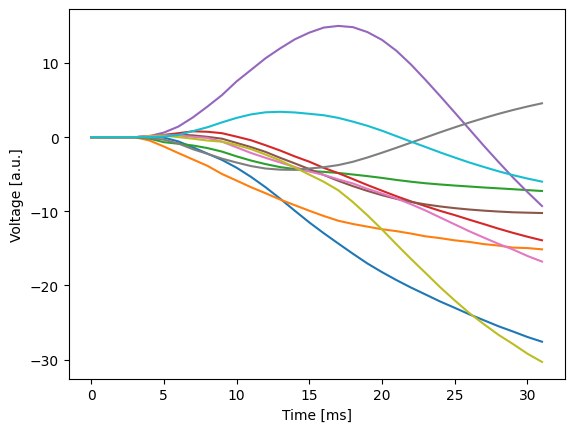

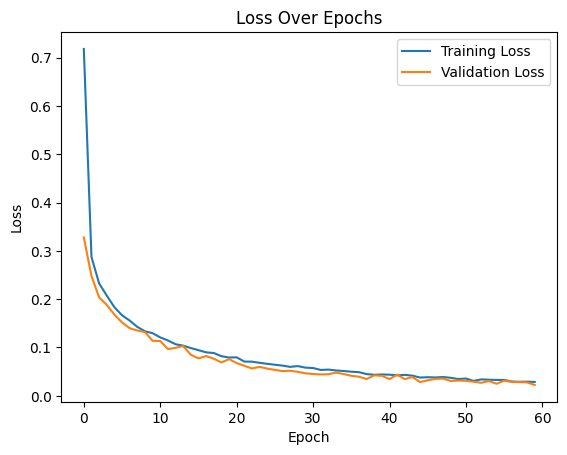

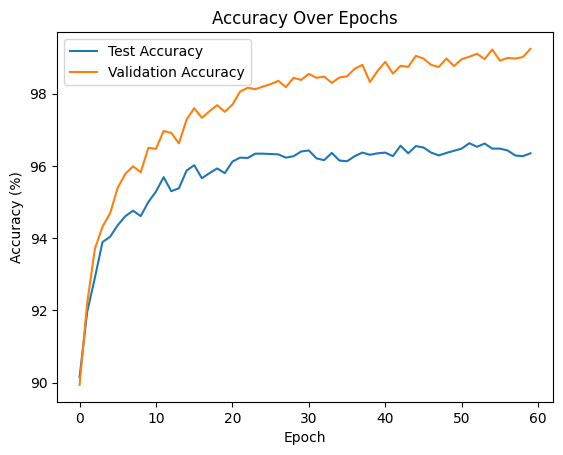

In [53]:
trained_snn = model.snn.cpu()
trained_readout_voltages = trained_snn(example_input.unsqueeze(1))
plt.plot(trained_readout_voltages.squeeze(1).detach().numpy())

plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()

# Beginn 23:10 60 Epochen Ende 00:12

# Plot für den Verlust
plt.plot(mean_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# Plot für die Genauigkeit
plt.plot(accuracies, label="Test Accuracy")
plt.plot(validation_accuracies, label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()


## Poison input

In [56]:
T = 32
LR = 0.002
INPUT_FEATURES = 28 * 28
HIDDEN_FEATURES = 100
OUTPUT_FEATURES = 10

if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

model = Model(
    encoder=encode.PoissonEncoder(T, f_max=20),
    snn=SNN(
        input_features=INPUT_FEATURES,
        hidden_features=HIDDEN_FEATURES,
        output_features=OUTPUT_FEATURES,
    ),
    decoder=decode,
).to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LR)
model

Model(
  (encoder): PoissonEncoder()
  (snn): SNN(
    (l1): LIFRecurrentCell(input_size=784, hidden_size=100, p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(0.5000), v_reset=tensor(0.), method='super', alpha=tensor(100)), autapses=False, dt=0.001)
    (fc_out): Linear(in_features=100, out_features=10, bias=False)
    (out): LICell(p=LIParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.)), dt=0.001)
  )
)

In [58]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in trange(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    
    # Training
    training_loss, mean_loss = train(
        model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS
    )
    
    # Test
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    
    # Validation
    val_loss, val_accuracy = validate(model, DEVICE, val_loader)
    
    # Update der Metriken
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy)
    
    # Falls NaN oder unendlicher Verlust erkannt wurde, breche das Training ab
    if mean_loss == 0.0 or test_loss == 0.0 or val_loss == 0.0:
        print("Training wegen NaN oder unendlichem Verlust abgebrochen.")
        break

    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train Loss: {mean_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Accuracy: {accuracy:.2f}%, "
          f"Validation Accuracy: {val_accuracy:.2f}%")

print(f"Final Test Accuracy: {accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {validation_accuracies[-1]:.2f}%")


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1/60 - Train Loss: 0.8058, Test Loss: 0.4703, Validation Loss: 0.4749, Accuracy: 85.18%, Validation Accuracy: 84.64%
Epoch 2/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/60 - Train Loss: 0.4187, Test Loss: 0.3578, Validation Loss: 0.3666, Accuracy: 88.93%, Validation Accuracy: 88.41%
Epoch 3/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/60 - Train Loss: 0.3501, Test Loss: 0.3199, Validation Loss: 0.3219, Accuracy: 89.87%, Validation Accuracy: 89.55%
Epoch 4/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4/60 - Train Loss: 0.3232, Test Loss: 0.2994, Validation Loss: 0.2962, Accuracy: 90.55%, Validation Accuracy: 90.64%
Epoch 5/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5/60 - Train Loss: 0.3062, Test Loss: 0.2913, Validation Loss: 0.2880, Accuracy: 91.01%, Validation Accuracy: 90.66%
Epoch 6/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6/60 - Train Loss: 0.2902, Test Loss: 0.2538, Validation Loss: 0.2571, Accuracy: 91.48%, Validation Accuracy: 91.77%
Epoch 7/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7/60 - Train Loss: 0.2740, Test Loss: 0.2555, Validation Loss: 0.2645, Accuracy: 91.74%, Validation Accuracy: 91.53%
Epoch 8/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8/60 - Train Loss: 0.2652, Test Loss: 0.2553, Validation Loss: 0.2507, Accuracy: 92.03%, Validation Accuracy: 92.15%
Epoch 9/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9/60 - Train Loss: 0.2571, Test Loss: 0.2550, Validation Loss: 0.2453, Accuracy: 92.01%, Validation Accuracy: 92.03%
Epoch 10/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10/60 - Train Loss: 0.2481, Test Loss: 0.2487, Validation Loss: 0.2434, Accuracy: 91.82%, Validation Accuracy: 91.90%
Epoch 11/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11/60 - Train Loss: 0.2364, Test Loss: 0.2198, Validation Loss: 0.2155, Accuracy: 93.14%, Validation Accuracy: 92.87%
Epoch 12/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12/60 - Train Loss: 0.2355, Test Loss: 0.2348, Validation Loss: 0.2245, Accuracy: 92.63%, Validation Accuracy: 92.92%
Epoch 13/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13/60 - Train Loss: 0.2278, Test Loss: 0.2207, Validation Loss: 0.2159, Accuracy: 93.18%, Validation Accuracy: 93.08%
Epoch 14/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14/60 - Train Loss: 0.2235, Test Loss: 0.2363, Validation Loss: 0.2340, Accuracy: 92.63%, Validation Accuracy: 92.66%
Epoch 15/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15/60 - Train Loss: 0.2178, Test Loss: 0.2189, Validation Loss: 0.2076, Accuracy: 93.02%, Validation Accuracy: 93.06%
Epoch 16/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16/60 - Train Loss: 0.2165, Test Loss: 0.2227, Validation Loss: 0.2032, Accuracy: 92.88%, Validation Accuracy: 93.55%
Epoch 17/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17/60 - Train Loss: 0.2054, Test Loss: 0.2093, Validation Loss: 0.2057, Accuracy: 93.35%, Validation Accuracy: 93.37%
Epoch 18/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18/60 - Train Loss: 0.2104, Test Loss: 0.2142, Validation Loss: 0.1977, Accuracy: 93.39%, Validation Accuracy: 93.51%
Epoch 19/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19/60 - Train Loss: 0.2004, Test Loss: 0.2423, Validation Loss: 0.2335, Accuracy: 92.49%, Validation Accuracy: 92.48%
Epoch 20/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 20/60 - Train Loss: 0.1991, Test Loss: 0.2315, Validation Loss: 0.2081, Accuracy: 92.78%, Validation Accuracy: 93.22%
Epoch 21/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 21/60 - Train Loss: 0.1940, Test Loss: 0.2070, Validation Loss: 0.1844, Accuracy: 93.49%, Validation Accuracy: 93.92%
Epoch 22/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 22/60 - Train Loss: 0.1960, Test Loss: 0.1931, Validation Loss: 0.1752, Accuracy: 93.96%, Validation Accuracy: 94.42%
Epoch 23/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 23/60 - Train Loss: 0.1881, Test Loss: 0.1929, Validation Loss: 0.1742, Accuracy: 93.89%, Validation Accuracy: 94.37%
Epoch 24/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 24/60 - Train Loss: 0.1906, Test Loss: 0.2135, Validation Loss: 0.2027, Accuracy: 92.96%, Validation Accuracy: 93.45%
Epoch 25/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 25/60 - Train Loss: 0.1846, Test Loss: 0.1951, Validation Loss: 0.1667, Accuracy: 93.70%, Validation Accuracy: 94.44%
Epoch 26/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 26/60 - Train Loss: 0.1803, Test Loss: 0.2002, Validation Loss: 0.1805, Accuracy: 93.75%, Validation Accuracy: 94.28%
Epoch 27/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 27/60 - Train Loss: 0.1818, Test Loss: 0.1903, Validation Loss: 0.1750, Accuracy: 94.11%, Validation Accuracy: 94.44%
Epoch 28/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 28/60 - Train Loss: 0.1874, Test Loss: 0.1926, Validation Loss: 0.1747, Accuracy: 93.93%, Validation Accuracy: 94.56%
Epoch 29/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 29/60 - Train Loss: 0.1752, Test Loss: 0.1816, Validation Loss: 0.1659, Accuracy: 94.18%, Validation Accuracy: 94.58%
Epoch 30/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 30/60 - Train Loss: 0.1698, Test Loss: 0.1909, Validation Loss: 0.1672, Accuracy: 94.14%, Validation Accuracy: 94.55%
Epoch 31/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 31/60 - Train Loss: 0.1716, Test Loss: 0.2137, Validation Loss: 0.1779, Accuracy: 93.58%, Validation Accuracy: 94.20%
Epoch 32/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 32/60 - Train Loss: 0.1645, Test Loss: 0.1776, Validation Loss: 0.1563, Accuracy: 94.24%, Validation Accuracy: 94.93%
Epoch 33/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 33/60 - Train Loss: 0.1602, Test Loss: 0.1749, Validation Loss: 0.1500, Accuracy: 94.47%, Validation Accuracy: 95.20%
Epoch 34/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 34/60 - Train Loss: 0.1599, Test Loss: 0.1792, Validation Loss: 0.1516, Accuracy: 94.41%, Validation Accuracy: 95.16%
Epoch 35/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 35/60 - Train Loss: 0.1584, Test Loss: 0.1815, Validation Loss: 0.1627, Accuracy: 94.22%, Validation Accuracy: 94.66%
Epoch 36/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 36/60 - Train Loss: 0.1603, Test Loss: 0.1610, Validation Loss: 0.1428, Accuracy: 94.72%, Validation Accuracy: 95.22%
Epoch 37/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 37/60 - Train Loss: 0.1576, Test Loss: 0.1751, Validation Loss: 0.1596, Accuracy: 94.66%, Validation Accuracy: 94.89%
Epoch 38/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 38/60 - Train Loss: 0.1524, Test Loss: 0.1680, Validation Loss: 0.1422, Accuracy: 94.79%, Validation Accuracy: 95.50%
Epoch 39/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 39/60 - Train Loss: 0.1558, Test Loss: 0.1655, Validation Loss: 0.1314, Accuracy: 94.94%, Validation Accuracy: 95.67%
Epoch 40/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 40/60 - Train Loss: 0.1500, Test Loss: 0.1621, Validation Loss: 0.1523, Accuracy: 94.93%, Validation Accuracy: 95.05%
Epoch 41/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 41/60 - Train Loss: 0.1469, Test Loss: 0.1692, Validation Loss: 0.1500, Accuracy: 94.51%, Validation Accuracy: 95.24%
Epoch 42/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 42/60 - Train Loss: 0.1488, Test Loss: 0.1792, Validation Loss: 0.1562, Accuracy: 94.33%, Validation Accuracy: 94.97%
Epoch 43/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 43/60 - Train Loss: 0.1457, Test Loss: 0.2083, Validation Loss: 0.1823, Accuracy: 93.57%, Validation Accuracy: 94.17%
Epoch 44/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 44/60 - Train Loss: 0.1528, Test Loss: 0.1585, Validation Loss: 0.1406, Accuracy: 94.94%, Validation Accuracy: 95.33%
Epoch 45/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 45/60 - Train Loss: 0.1417, Test Loss: 0.1649, Validation Loss: 0.1554, Accuracy: 94.81%, Validation Accuracy: 95.16%
Epoch 46/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 46/60 - Train Loss: 0.1429, Test Loss: 0.1489, Validation Loss: 0.1322, Accuracy: 95.22%, Validation Accuracy: 95.69%
Epoch 47/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 47/60 - Train Loss: 0.1405, Test Loss: 0.1407, Validation Loss: 0.1237, Accuracy: 95.32%, Validation Accuracy: 96.02%
Epoch 48/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 48/60 - Train Loss: 0.1362, Test Loss: 0.1669, Validation Loss: 0.1387, Accuracy: 94.47%, Validation Accuracy: 95.50%
Epoch 49/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 49/60 - Train Loss: 0.1390, Test Loss: 0.1506, Validation Loss: 0.1273, Accuracy: 95.24%, Validation Accuracy: 95.95%
Epoch 50/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 50/60 - Train Loss: 0.1385, Test Loss: 0.1427, Validation Loss: 0.1159, Accuracy: 95.59%, Validation Accuracy: 96.07%
Epoch 51/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 51/60 - Train Loss: 0.1346, Test Loss: 0.1561, Validation Loss: 0.1329, Accuracy: 95.19%, Validation Accuracy: 95.83%
Epoch 52/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 52/60 - Train Loss: 0.1336, Test Loss: 0.1445, Validation Loss: 0.1257, Accuracy: 95.57%, Validation Accuracy: 96.08%
Epoch 53/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 53/60 - Train Loss: 0.1333, Test Loss: 0.1528, Validation Loss: 0.1228, Accuracy: 95.34%, Validation Accuracy: 96.08%
Epoch 54/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 54/60 - Train Loss: 0.1339, Test Loss: 0.1549, Validation Loss: 0.1281, Accuracy: 95.17%, Validation Accuracy: 95.77%
Epoch 55/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 55/60 - Train Loss: 0.1334, Test Loss: 0.1461, Validation Loss: 0.1311, Accuracy: 95.38%, Validation Accuracy: 95.74%
Epoch 56/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 56/60 - Train Loss: 0.1322, Test Loss: 0.1447, Validation Loss: 0.1258, Accuracy: 95.35%, Validation Accuracy: 95.96%
Epoch 57/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 57/60 - Train Loss: 0.1300, Test Loss: 0.1491, Validation Loss: 0.1204, Accuracy: 95.29%, Validation Accuracy: 96.04%
Epoch 58/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 58/60 - Train Loss: 0.1303, Test Loss: 0.1455, Validation Loss: 0.1186, Accuracy: 95.37%, Validation Accuracy: 96.05%
Epoch 59/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 59/60 - Train Loss: 0.1261, Test Loss: 0.1377, Validation Loss: 0.1197, Accuracy: 95.63%, Validation Accuracy: 96.11%
Epoch 60/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 60/60 - Train Loss: 0.1262, Test Loss: 0.1481, Validation Loss: 0.1213, Accuracy: 95.17%, Validation Accuracy: 95.96%
Final Test Accuracy: 95.17%
Final Validation Accuracy: 95.96%


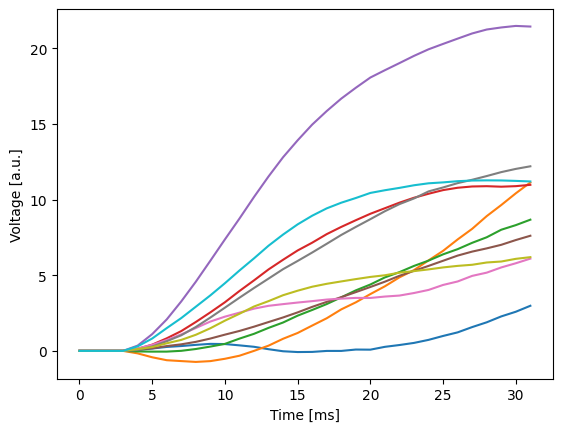

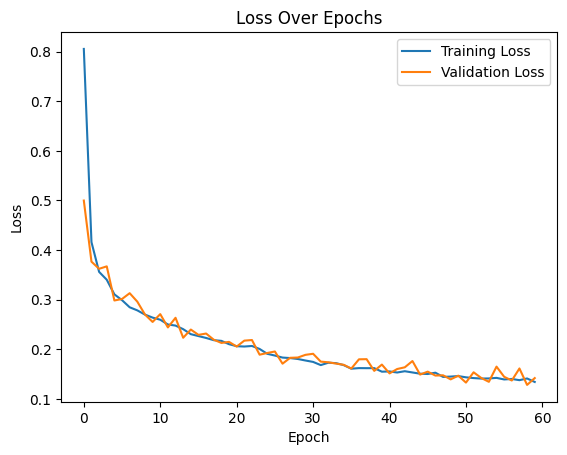

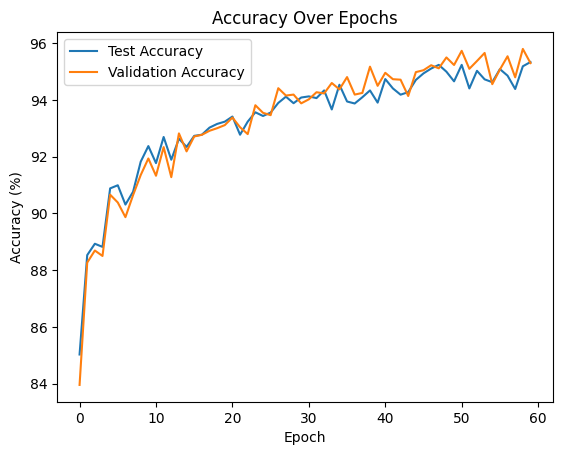

In [157]:
trained_snn = model.snn.cpu()
trained_readout_voltages = trained_snn(example_input.unsqueeze(1))
plt.plot(trained_readout_voltages.squeeze(1).detach().numpy())

plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.show()

# Beginn 10:04 60 Epochen Ende 10:51

# Plot für den Verlust
plt.plot(mean_losses, label="Training Loss")
plt.plot(validation_losses, label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.show()

# Plot für die Genauigkeit
plt.plot(accuracies, label="Test Accuracy")
plt.plot(validation_accuracies, label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.show()

## Convulutional SNN

In [159]:
from norse.torch.module.leaky_integrator import LILinearCell
from norse.torch.functional.lif import LIFFeedForwardState
from norse.torch.functional.leaky_integrator import LIState
import torch.nn as nn

from typing import NamedTuple


class ConvNet(torch.nn.Module):
    def __init__(self, num_channels=1, feature_size=28, method="super", alpha=100):
        super(ConvNet, self).__init__()

        self.features = int(((feature_size - 4) / 2 - 4) / 2)

        self.conv1 = torch.nn.Conv2d(num_channels, 20, 5, 1)
        self.conv2 = torch.nn.Conv2d(20, 50, 5, 1)
        self.fc1 = torch.nn.Linear(self.features * self.features * 50, 500)
        self.lif0 = LIFCell(p=LIFParameters(method=method, alpha=alpha))
        self.lif1 = LIFCell(p=LIFParameters(method=method, alpha=alpha))
        self.lif2 = LIFCell(p=LIFParameters(method=method, alpha=alpha))
        self.out = LILinearCell(500, 10)

    def forward(self, x):
        seq_length = x.shape[0]
        batch_size = x.shape[1]

        # specify the initial states
        s0 = s1 = s2 = so = None

        voltages = torch.zeros(
            seq_length, batch_size, 10, device=x.device, dtype=x.dtype
        )

        for ts in range(seq_length):
            z = self.conv1(x[ts, :])
            z, s0 = self.lif0(z, s0)
            z = torch.nn.functional.max_pool2d(z, 2, 2)
            z = 10 * self.conv2(z)
            z, s1 = self.lif1(z, s1)
            z = torch.nn.functional.max_pool2d(z, 2, 2)
            z = z.view(-1, 4**2 * 50)
            z = self.fc1(z)
            z, s2 = self.lif2(z, s2)
            v, so = self.out(torch.nn.functional.relu(z), so)
            voltages[ts, :, :] = v
        return voltages

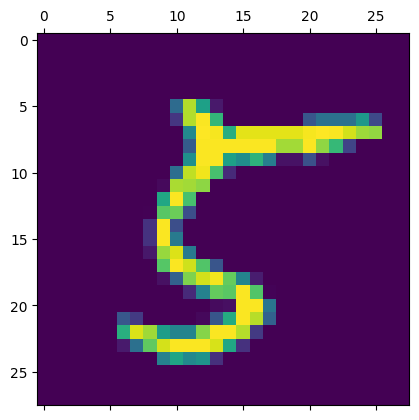

5


In [161]:
img, label = train_data[1]

plt.matshow(img[0])
plt.show()
print(label)

In [163]:
training_losses = []
mean_losses = []
test_losses = []
accuracies = []
validation_losses = []
validation_accuracies = []

for epoch in trange(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    
    # Training
    training_loss, mean_loss = train(
        model, DEVICE, train_loader, optimizer, epoch, max_epochs=EPOCHS
    )
    
    # Test
    test_loss, accuracy = test(model, DEVICE, test_loader, epoch)
    
    # Validation
    val_loss, val_accuracy = validate(model, DEVICE, val_loader)
    
    # Update der Metriken
    training_losses += training_loss
    mean_losses.append(mean_loss)
    test_losses.append(test_loss)
    accuracies.append(accuracy)
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy)
    
    # Falls NaN oder unendlicher Verlust erkannt wurde, breche das Training ab
    if mean_loss == 0.0 or test_loss == 0.0 or val_loss == 0.0:
        print("Training wegen NaN oder unendlichem Verlust abgebrochen.")
        break

    print(f"Epoch {epoch+1}/{EPOCHS} - "
          f"Train Loss: {mean_loss:.4f}, "
          f"Test Loss: {test_loss:.4f}, "
          f"Validation Loss: {val_loss:.4f}, "
          f"Accuracy: {accuracy:.2f}%, "
          f"Validation Accuracy: {val_accuracy:.2f}%")

print(f"Final Test Accuracy: {accuracies[-1]:.2f}%")
print(f"Final Validation Accuracy: {validation_accuracies[-1]:.2f}%")


  0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1/60 - Train Loss: 0.1367, Test Loss: 0.1738, Validation Loss: 0.1500, Accuracy: 94.58%, Validation Accuracy: 94.97%
Epoch 2/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 2/60 - Train Loss: 0.1307, Test Loss: 0.1366, Validation Loss: 0.1163, Accuracy: 95.79%, Validation Accuracy: 96.14%
Epoch 3/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 3/60 - Train Loss: 0.1334, Test Loss: 0.1613, Validation Loss: 0.1346, Accuracy: 94.98%, Validation Accuracy: 95.32%
Epoch 4/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 4/60 - Train Loss: 0.1362, Test Loss: 0.1467, Validation Loss: 0.1240, Accuracy: 95.19%, Validation Accuracy: 96.10%
Epoch 5/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 5/60 - Train Loss: 0.1281, Test Loss: 0.1425, Validation Loss: 0.1272, Accuracy: 95.45%, Validation Accuracy: 95.67%
Epoch 6/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 6/60 - Train Loss: 0.1280, Test Loss: 0.1567, Validation Loss: 0.1301, Accuracy: 94.99%, Validation Accuracy: 95.85%
Epoch 7/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 7/60 - Train Loss: 0.1349, Test Loss: 0.1547, Validation Loss: 0.1276, Accuracy: 95.13%, Validation Accuracy: 95.69%
Epoch 8/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 8/60 - Train Loss: 0.1275, Test Loss: 0.1535, Validation Loss: 0.1254, Accuracy: 95.30%, Validation Accuracy: 95.82%
Epoch 9/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 9/60 - Train Loss: 0.1312, Test Loss: 0.1552, Validation Loss: 0.1337, Accuracy: 95.30%, Validation Accuracy: 95.63%
Epoch 10/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 10/60 - Train Loss: 0.1303, Test Loss: 0.1686, Validation Loss: 0.1412, Accuracy: 95.03%, Validation Accuracy: 95.46%
Epoch 11/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 11/60 - Train Loss: 0.1280, Test Loss: 0.1379, Validation Loss: 0.1159, Accuracy: 95.77%, Validation Accuracy: 96.20%
Epoch 12/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 12/60 - Train Loss: 0.1211, Test Loss: 0.1481, Validation Loss: 0.1327, Accuracy: 95.39%, Validation Accuracy: 95.71%
Epoch 13/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 13/60 - Train Loss: 0.1262, Test Loss: 0.1483, Validation Loss: 0.1297, Accuracy: 95.53%, Validation Accuracy: 95.77%
Epoch 14/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 14/60 - Train Loss: 0.1235, Test Loss: 0.1472, Validation Loss: 0.1211, Accuracy: 95.36%, Validation Accuracy: 95.94%
Epoch 15/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 15/60 - Train Loss: 0.1321, Test Loss: 0.1460, Validation Loss: 0.1224, Accuracy: 95.33%, Validation Accuracy: 95.74%
Epoch 16/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 16/60 - Train Loss: 0.1263, Test Loss: 0.1522, Validation Loss: 0.1232, Accuracy: 95.18%, Validation Accuracy: 95.89%
Epoch 17/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 17/60 - Train Loss: 0.1280, Test Loss: 0.1418, Validation Loss: 0.1171, Accuracy: 95.40%, Validation Accuracy: 96.10%
Epoch 18/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 18/60 - Train Loss: 0.1242, Test Loss: 0.1603, Validation Loss: 0.1259, Accuracy: 95.17%, Validation Accuracy: 95.83%
Epoch 19/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 19/60 - Train Loss: 0.1156, Test Loss: 0.1380, Validation Loss: 0.1130, Accuracy: 95.66%, Validation Accuracy: 96.24%
Epoch 20/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 20/60 - Train Loss: 0.1210, Test Loss: 0.1438, Validation Loss: 0.1256, Accuracy: 95.59%, Validation Accuracy: 95.79%
Epoch 21/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 21/60 - Train Loss: 0.1161, Test Loss: 0.1461, Validation Loss: 0.1251, Accuracy: 95.30%, Validation Accuracy: 95.88%
Epoch 22/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 22/60 - Train Loss: 0.1179, Test Loss: 0.1365, Validation Loss: 0.1017, Accuracy: 95.82%, Validation Accuracy: 96.56%
Epoch 23/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 23/60 - Train Loss: 0.1168, Test Loss: 0.1391, Validation Loss: 0.1156, Accuracy: 95.77%, Validation Accuracy: 96.12%
Epoch 24/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 24/60 - Train Loss: 0.1175, Test Loss: 0.1338, Validation Loss: 0.1040, Accuracy: 96.00%, Validation Accuracy: 96.44%
Epoch 25/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 25/60 - Train Loss: 0.1153, Test Loss: 0.1407, Validation Loss: 0.1271, Accuracy: 95.68%, Validation Accuracy: 95.84%
Epoch 26/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 26/60 - Train Loss: 0.1173, Test Loss: 0.1377, Validation Loss: 0.1164, Accuracy: 95.56%, Validation Accuracy: 96.15%
Epoch 27/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 27/60 - Train Loss: 0.1169, Test Loss: 0.1521, Validation Loss: 0.1259, Accuracy: 95.39%, Validation Accuracy: 95.69%
Epoch 28/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 28/60 - Train Loss: 0.1141, Test Loss: 0.1361, Validation Loss: 0.1089, Accuracy: 95.83%, Validation Accuracy: 96.41%
Epoch 29/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 29/60 - Train Loss: 0.1181, Test Loss: 0.1511, Validation Loss: 0.1239, Accuracy: 95.40%, Validation Accuracy: 95.95%
Epoch 30/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 30/60 - Train Loss: 0.1165, Test Loss: 0.1308, Validation Loss: 0.1142, Accuracy: 95.86%, Validation Accuracy: 96.14%
Epoch 31/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 31/60 - Train Loss: 0.1153, Test Loss: 0.1441, Validation Loss: 0.1062, Accuracy: 95.66%, Validation Accuracy: 96.32%
Epoch 32/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 32/60 - Train Loss: 0.1113, Test Loss: 0.1413, Validation Loss: 0.1213, Accuracy: 95.58%, Validation Accuracy: 96.05%
Epoch 33/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 33/60 - Train Loss: 0.1133, Test Loss: 0.1459, Validation Loss: 0.1145, Accuracy: 95.44%, Validation Accuracy: 96.15%
Epoch 34/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 34/60 - Train Loss: 0.1133, Test Loss: 0.1184, Validation Loss: 0.1025, Accuracy: 96.27%, Validation Accuracy: 96.55%
Epoch 35/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 35/60 - Train Loss: 0.1144, Test Loss: 0.1417, Validation Loss: 0.1106, Accuracy: 95.56%, Validation Accuracy: 96.26%
Epoch 36/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 36/60 - Train Loss: 0.1126, Test Loss: 0.1369, Validation Loss: 0.1097, Accuracy: 95.74%, Validation Accuracy: 96.42%
Epoch 37/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 37/60 - Train Loss: 0.1127, Test Loss: 0.1338, Validation Loss: 0.1010, Accuracy: 95.90%, Validation Accuracy: 96.62%
Epoch 38/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 38/60 - Train Loss: 0.1125, Test Loss: 0.1371, Validation Loss: 0.1166, Accuracy: 95.55%, Validation Accuracy: 96.08%
Epoch 39/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 39/60 - Train Loss: 0.1124, Test Loss: 0.1436, Validation Loss: 0.1083, Accuracy: 95.63%, Validation Accuracy: 96.37%
Epoch 40/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 40/60 - Train Loss: 0.1116, Test Loss: 0.1416, Validation Loss: 0.1160, Accuracy: 95.50%, Validation Accuracy: 96.30%
Epoch 41/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 41/60 - Train Loss: 0.1080, Test Loss: 0.1282, Validation Loss: 0.1015, Accuracy: 96.17%, Validation Accuracy: 96.62%
Epoch 42/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 42/60 - Train Loss: 0.1103, Test Loss: 0.1318, Validation Loss: 0.1063, Accuracy: 95.79%, Validation Accuracy: 96.53%
Epoch 43/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 43/60 - Train Loss: 0.1116, Test Loss: 0.1446, Validation Loss: 0.1129, Accuracy: 95.76%, Validation Accuracy: 96.15%
Epoch 44/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 44/60 - Train Loss: 0.1070, Test Loss: 0.1269, Validation Loss: 0.1024, Accuracy: 95.86%, Validation Accuracy: 96.72%
Epoch 45/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 45/60 - Train Loss: 0.1074, Test Loss: 0.1272, Validation Loss: 0.1042, Accuracy: 95.84%, Validation Accuracy: 96.52%
Epoch 46/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 46/60 - Train Loss: 0.1025, Test Loss: 0.1306, Validation Loss: 0.0982, Accuracy: 96.13%, Validation Accuracy: 96.62%
Epoch 47/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 47/60 - Train Loss: 0.1144, Test Loss: 0.1299, Validation Loss: 0.1059, Accuracy: 95.97%, Validation Accuracy: 96.43%
Epoch 48/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 48/60 - Train Loss: 0.1166, Test Loss: 0.1601, Validation Loss: 0.1313, Accuracy: 95.35%, Validation Accuracy: 95.65%
Epoch 49/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 49/60 - Train Loss: 0.1069, Test Loss: 0.1322, Validation Loss: 0.1026, Accuracy: 95.91%, Validation Accuracy: 96.58%
Epoch 50/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 50/60 - Train Loss: 0.1084, Test Loss: 0.1478, Validation Loss: 0.1143, Accuracy: 95.30%, Validation Accuracy: 96.30%
Epoch 51/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 51/60 - Train Loss: 0.1123, Test Loss: 0.1303, Validation Loss: 0.1006, Accuracy: 96.02%, Validation Accuracy: 96.67%
Epoch 52/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 52/60 - Train Loss: 0.1079, Test Loss: 0.1260, Validation Loss: 0.1041, Accuracy: 96.09%, Validation Accuracy: 96.57%
Epoch 53/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 53/60 - Train Loss: 0.1080, Test Loss: 0.1362, Validation Loss: 0.1054, Accuracy: 95.62%, Validation Accuracy: 96.47%
Epoch 54/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 54/60 - Train Loss: 0.1090, Test Loss: 0.1388, Validation Loss: 0.1113, Accuracy: 95.71%, Validation Accuracy: 96.49%
Epoch 55/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 55/60 - Train Loss: 0.1075, Test Loss: 0.1297, Validation Loss: 0.0952, Accuracy: 95.88%, Validation Accuracy: 96.83%
Epoch 56/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 56/60 - Train Loss: 0.1038, Test Loss: 0.1411, Validation Loss: 0.1125, Accuracy: 95.87%, Validation Accuracy: 96.18%
Epoch 57/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 57/60 - Train Loss: 0.1053, Test Loss: 0.1282, Validation Loss: 0.0983, Accuracy: 96.04%, Validation Accuracy: 96.83%
Epoch 58/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 58/60 - Train Loss: 0.1083, Test Loss: 0.1288, Validation Loss: 0.1089, Accuracy: 96.07%, Validation Accuracy: 96.12%
Epoch 59/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 59/60 - Train Loss: 0.1032, Test Loss: 0.1213, Validation Loss: 0.0999, Accuracy: 96.13%, Validation Accuracy: 96.65%
Epoch 60/60


  0%|          | 0/235 [00:00<?, ?it/s]

Epoch 60/60 - Train Loss: 0.1075, Test Loss: 0.1354, Validation Loss: 0.1044, Accuracy: 95.98%, Validation Accuracy: 96.60%
Final Test Accuracy: 95.98%
Final Validation Accuracy: 96.60%


torch.Size([32, 1, 10])


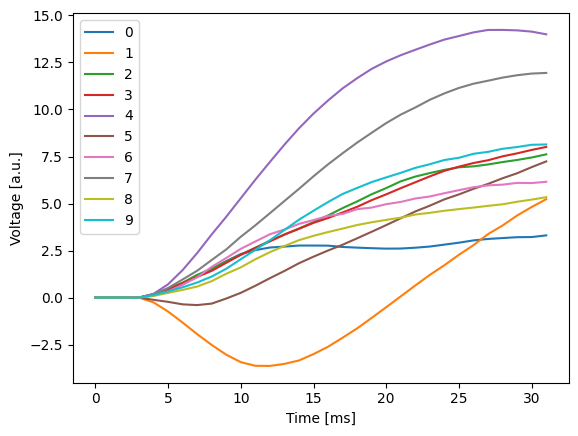

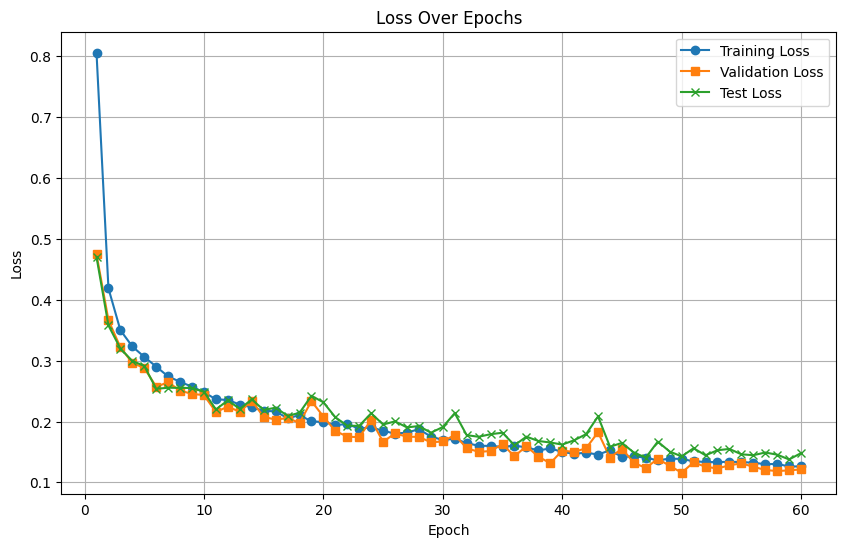

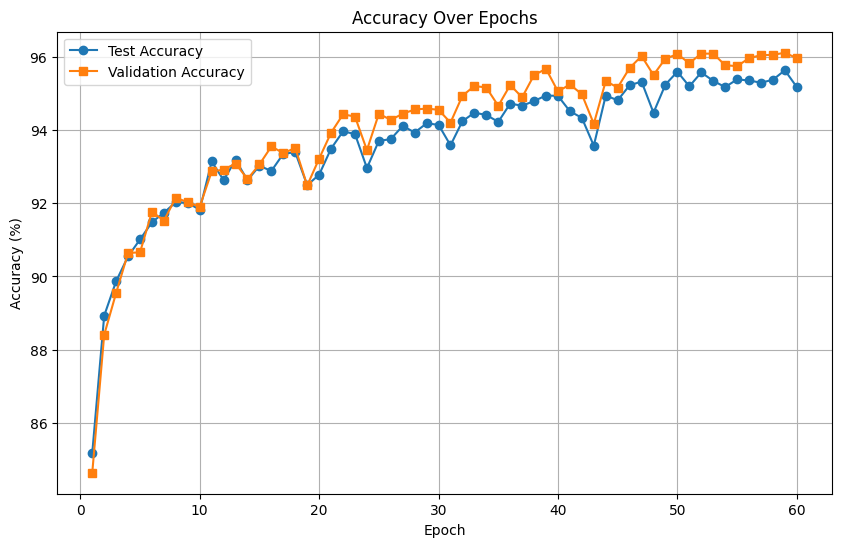

In [60]:
trained_snn = model.snn.cpu()

# Beginn 10:52 60 Epochen Ende 11:31


trained_readout_voltages = trained_snn(example_input.unsqueeze(1))

print(trained_readout_voltages.shape)

for i in range(10):
    plt.plot(
        trained_readout_voltages[:, :, i].squeeze(1).detach().numpy(), label=f"{i}"
    )

plt.ylabel("Voltage [a.u.]")
plt.xlabel("Time [ms]")
plt.legend()
plt.show()


# Plot für Verluste
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mean_losses) + 1), mean_losses, label="Training Loss", marker="o")
plt.plot(range(1, len(validation_losses) + 1), validation_losses, label="Validation Loss", marker="s")
plt.plot(range(1, len(test_losses) + 1), test_losses, label="Test Loss", marker="x")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# Plot für Genauigkeiten
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(accuracies) + 1), accuracies, label="Test Accuracy", marker="o")
plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label="Validation Accuracy", marker="s")
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


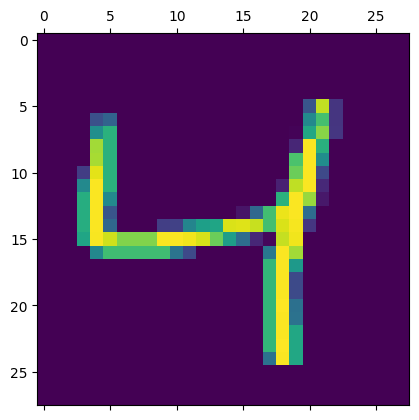

In [62]:
plt.matshow(np.squeeze(img, 0))